# Multimodal RAG Quickstart with LlamaCloud

<a href="https://colab.research.google.com/github/run-llama/llamacloud-demo/blob/main/examples/multimodal/getting_started_mm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows you how to get started by building a simple Multi-Modal RAG pipeline over the [Conoco Phillips 2023 investor meeting slide deck](https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf).

## Build Multimodal LlamaCloud Index

We first build a multimodal LlamaCloud Index (a RAG pipeline) over the Conoco Phillips deck.

To create the index, follow the instructions:
1. You can download the [file](https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf).
2. In the "Create Index" page, make sure to toggle the **Multi-Modal Indexing** option. This will also render page screenshots for every document and store/index them along with the text for retrieval.
3. If you wish you can also customize the LlamaParse settings for text extraction (including using a multi-modal model for text extraction too).

After the index is created, you're welcome to check out the Playground. Make sure to toggle "Multi-modal Retrieval". Given a question, you will get answers over image and text data, and both the text and image sources will show up.

![](getting_started_mm_images/playground.png)
![](getting_started_mm_images/image_source.png)

## Build Multi-modal RAG Pipeline Through Code

Now that the index is setup, we're ready to integrate it into code.

In [ ]:
!pip install llama-index-indices-llama-cloud

In [1]:
from llama_index.indices.managed.llama_cloud import LlamaCloudIndex

index = LlamaCloudIndex(
  name="<index_name>", 
  project_name="<project_name>",
  organization_id="...",
  api_key="llx-..."
)

## Multimodal Retrieval

Let's first define a multimodal retriever - we'll see that we're able to return both text and image nodes.

In [2]:
from PIL import Image 
from llama_index.core.schema import ImageNode
from IPython.display import display

def _render_image_nodes(nodes):
    # go through nodes, render the ones that are image nodes
    image_nodes = [n for n in nodes if isinstance(n.node, ImageNode)]
    for image_node in image_nodes:
        image = Image.open(image_node.node.resolve_image())
        display(image)

In [3]:
retriever = index.as_retriever(retrieve_image_nodes=True)

In [ ]:
nodes = retriever.retrieve("Tell me about the diverse geographies which represent the production bases")

The first few nodes are all TextNodes. We can easily filter for image nodes and render them.

# Our Differentiated Portfolio: Deep; Durable and Diverse

# Diverse Production Base

|Resource (BBOE)|Lower 48|Canada|Alaska|EMENA|Asia Pacific|
|---|---|---|---|---|---|
|10| | | | | |
|15| | | | | |
|20| | | | | |

# 10-Year Plan Cumulative Production (BBOE)

|Region|Resource (BBOE)|
|---|---|
|Lower 48| |
|Alaska| |
|GKA| |
|GWA| |
|GPA| |
|WNS| |
|EMENA| |
|Norway| |
|Qatar| |
|Libya| |
|Asia Pacific| |
|Canada| |
|Permian| |
|APLNG| |
|Montney| |
|Bakken| |
|Eagle Ford| |
|Other| |
|Malaysia| |
|China| |
|Surmont| |

Costs assume mid-cycle price environment of $60/BBL WTI:

ConocoPhillips


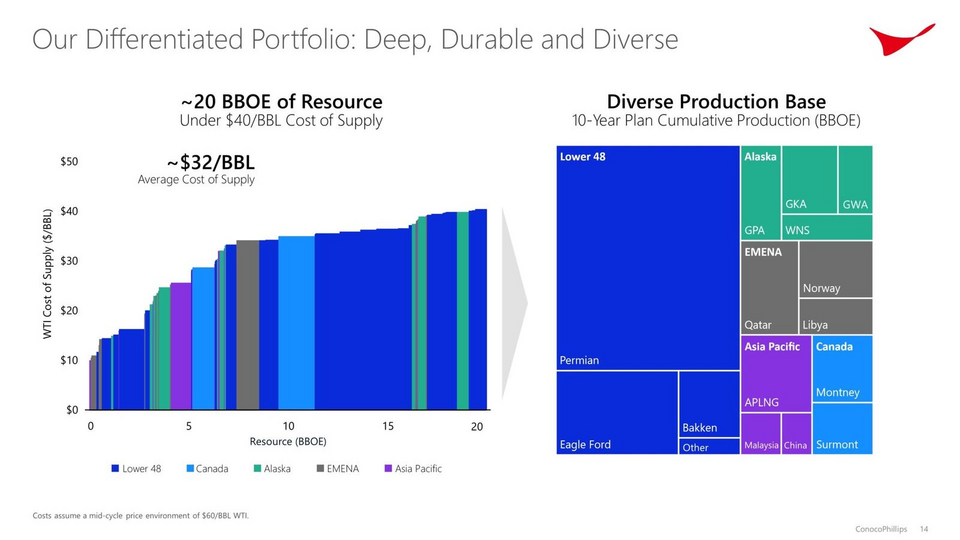

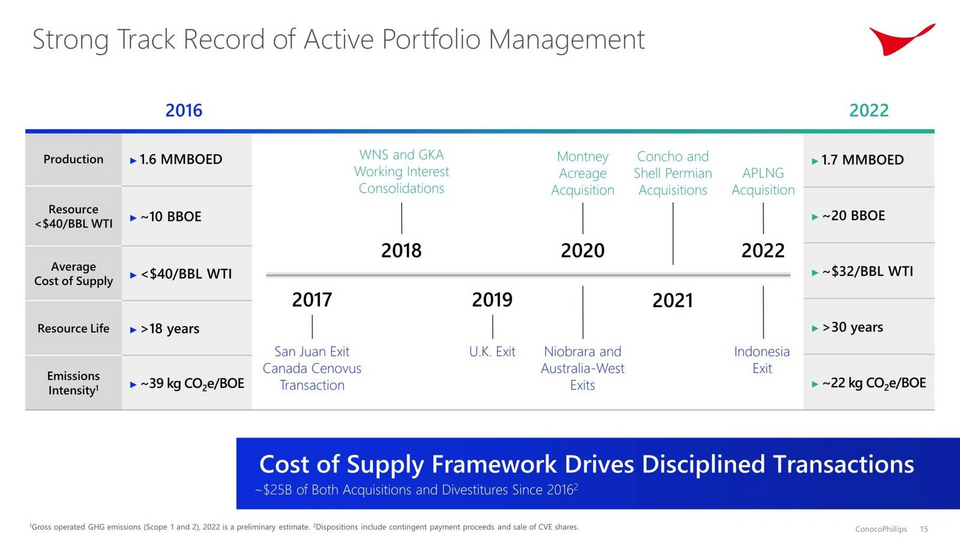

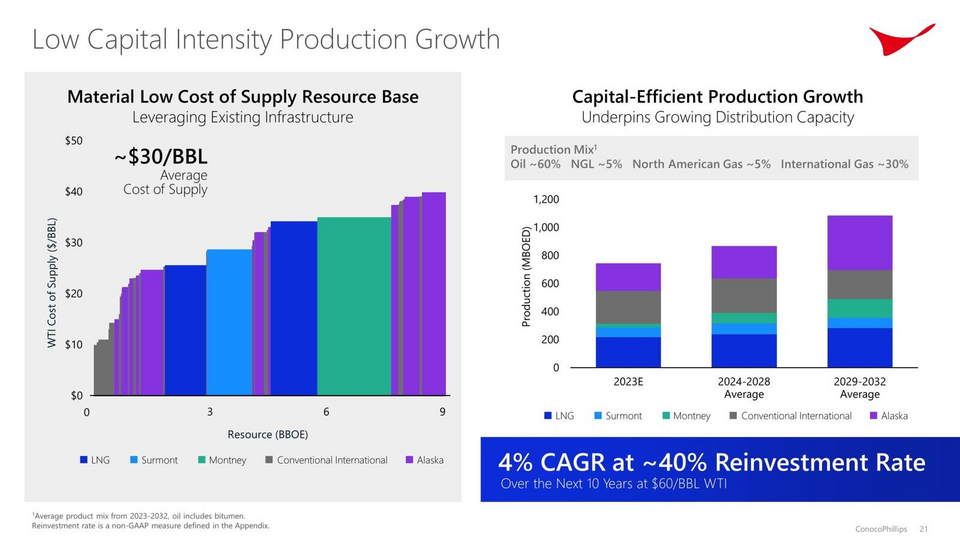

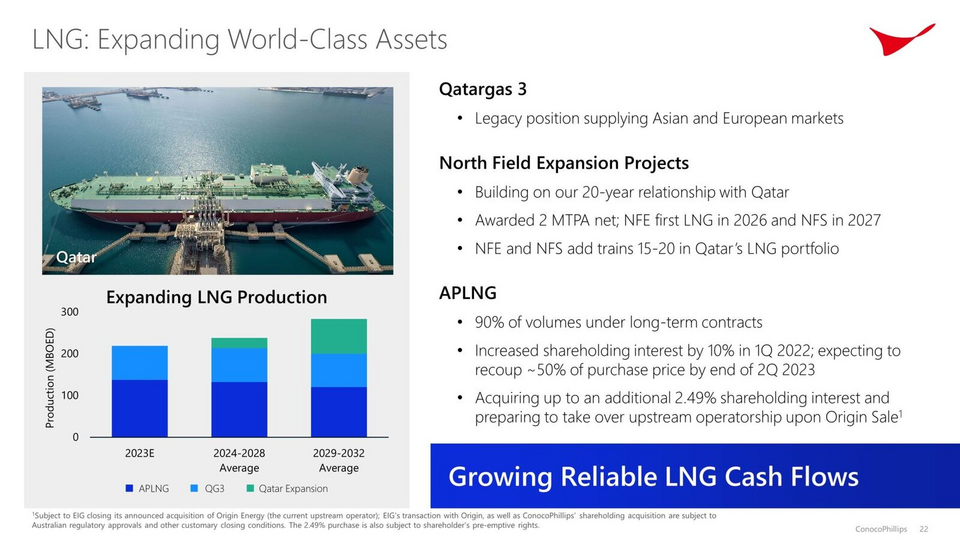

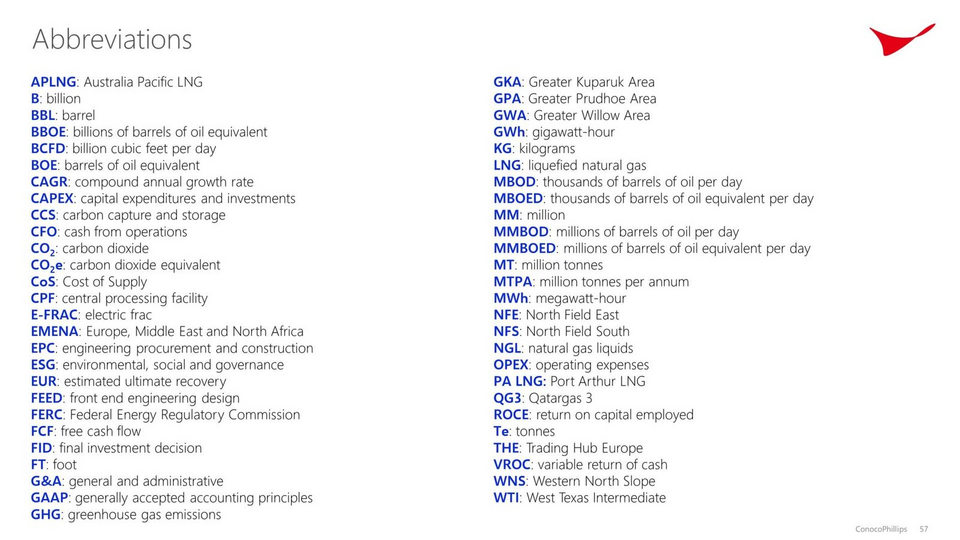

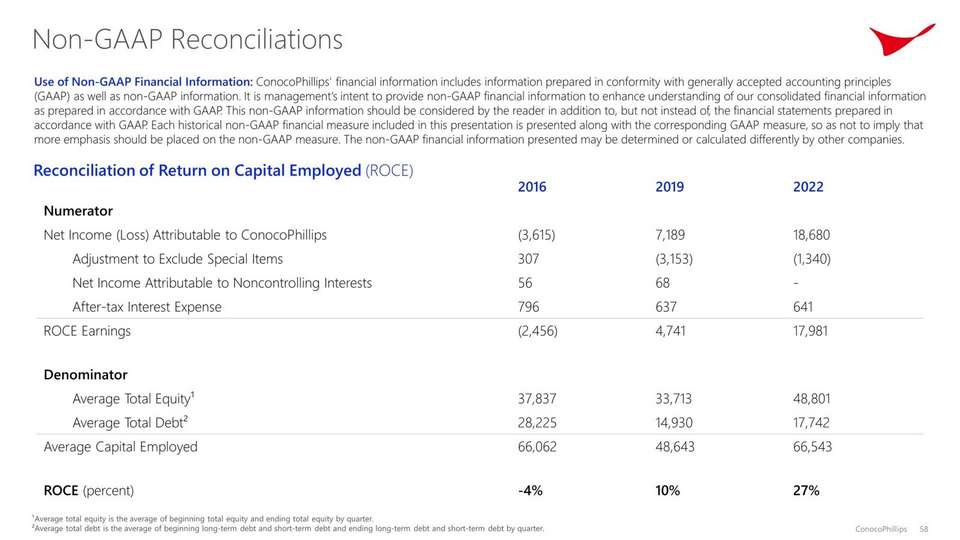

In [5]:
print(nodes[0].get_content())

_render_image_nodes(nodes)

## Try out an Example Query! 

Now we can try out an example query against the multimodal index. Here we build a custom multi-modal query engine, since our default `RetrieverQueryEngine` only operates over text nodes.

In [6]:
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode, TextNode
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from typing import Optional


gpt_4o = OpenAIMultiModal(model="gpt-4o", max_new_tokens=4096)

QA_PROMPT_TMPL = """\
Below we give parsed text and images as context.

Use both the parsed text and images to answer the question. 

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)

class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine.

    Takes in a retriever to retrieve a set of document nodes.
    Also takes in a prompt template and multimodal model.

    """

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: OpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str):
        # retrieve text nodes
        nodes = self.retriever.retrieve(query_str)
        img_nodes = [n for n in nodes if isinstance(n.node, ImageNode)]
        text_nodes = [n for n in nodes if isinstance(n.node, TextNode)]
        
        # create context string from text nodes, dump into the prompt
        context_str = "\n\n".join(
            [r.get_content(metadata_mode=MetadataMode.LLM) for r in nodes]
        )
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)

        # synthesize an answer from formatted text and images
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[n.node for n in img_nodes],
        )
        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": text_nodes, "image_nodes": img_nodes},
        )

        return response

In [7]:
query_engine = MultimodalQueryEngine(retriever=retriever, multi_modal_llm=gpt_4o)

In [8]:
response = query_engine.query("Tell me about the diverse geographies which represent the production bases")

In [9]:
print(str(response))

The diverse geographies representing the production bases for ConocoPhillips include:

1. **Lower 48 (United States)**
2. **Canada**
3. **Alaska**
4. **EMENA (Europe, Middle East, and North Africa)**
5. **Asia Pacific**

This information is derived from the text and images provided in the presentation. The text lists various regions under the "10-Year Plan Cumulative Production (BBOE)" and the "Diverse Production Base" sections, while the images visually represent these regions and their contributions to the production base. There are no discrepancies between the text and images regarding the diverse geographies.


In [ ]:
_render_image_nodes(response.metadata["image_nodes"][:2])

In [ ]:
response = query_engine.query("How much has GHG intensity reduced in the lower 48?")

In [12]:
print(str(response))

The GHG intensity in the lower 48 has reduced by approximately 50%. This information is derived from the first image under the section "Delivering on Emissions Reductions and Sustainable Development," which shows a comparison between 2019 and 2022, indicating a ~50% reduction in Lower 48 GHG Intensity (kg CO2/BOE).


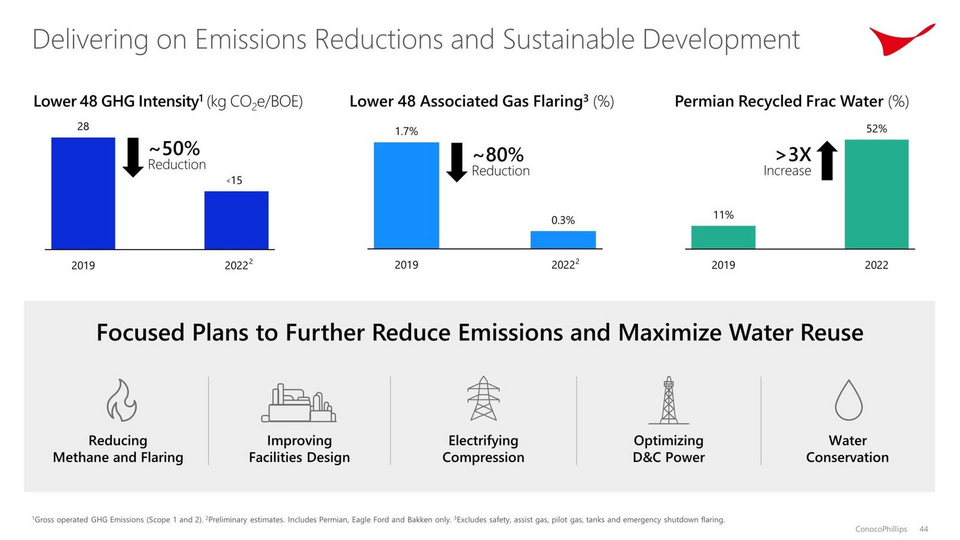

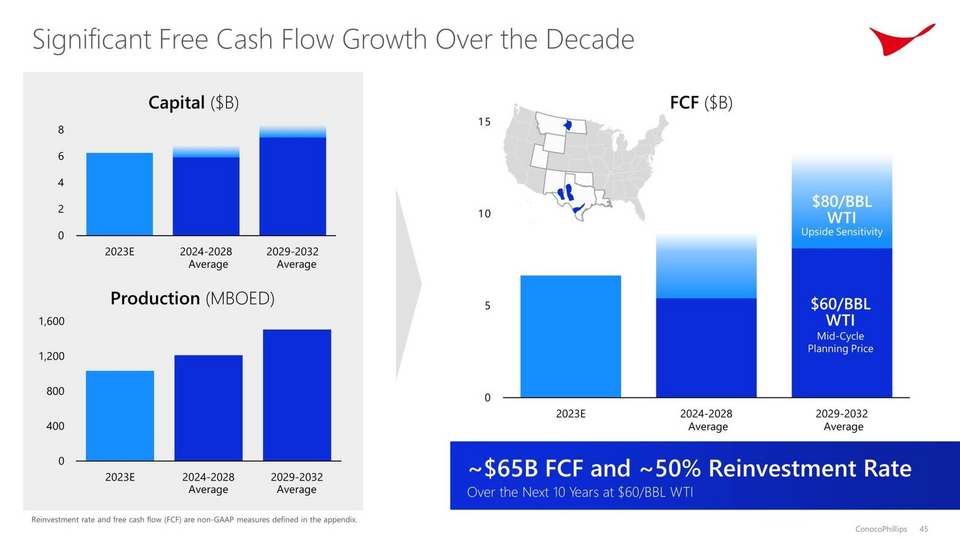

In [13]:
# just look at the top two images
_render_image_nodes(response.metadata["image_nodes"][:2])